In [2]:
%matplotlib inline


# Self-supervised learning on EEG with relative positioning

This example shows how to train a neural network with self-supervision on sleep
EEG data. We follow the relative positioning approach of [1]_ on the openly
accessible Sleep Physionet dataset [2]_ [3]_.

.. topic:: Self-supervised learning

    Self-supervised learning (SSL) is a learning paradigm that leverages
    unlabelled data to train neural networks. First, neural networks are
    trained on a "pretext task" which uses unlabelled data only. The pretext
    task is designed based on a prior understanding of the data under study
    (e.g., EEG has an underlying autocorrelation struture) and such that the
    processing required to perform well on this pretext task is related to the
    processing required to perform well on another task of interest.
    Once trained, these neural networks can be reused as feature extractors or
    weight initialization in a "downstream task", which is the task that we are
    actually interested in (e.g., sleep staging). The pretext task step can
    help reduce the quantity of labelled data needed to perform well on the
    downstream task and/or improve downstream performance as compared to a
    strictly supervised approach [1]_.

Here, we use relative positioning (RP) as our pretext task, and perform sleep
staging as our downstream task. RP is a simple SSL task, in which a neural
network is trained to predict whether two randomly sampled EEG windows are
close or far apart in time. This method was shown to yield physiologically- and
clinically-relevant features and to boost classification performance in
low-labels data regimes [1]_.
   :depth: 2


In [3]:
# Authors: Hubert Banville <hubert.jbanville@gmail.com>
#
# License: BSD (3-clause)

from braindecode.datasets.sleep_physionet import SleepPhysionet
import pickle
import numpy as np
import mne
import matplotlib.pyplot as plt

random_state = 87
n_jobs = 1

# sample data for which we are trying to generate predictions of the input data using a part of the SSL pre-trained model
path_to_sample = "/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/braindecode_code/sleep_staging_dataset/"

## Loading and preprocessing the dataset




### Loading the raw recordings




First, we load a few recordings from the Sleep Physionet dataset. Running
this example with more recordings should yield better representations and
downstream classification performance.




In [4]:
dataset = SleepPhysionet(
    subject_ids=[0,1,2,3],
    recording_ids=[1]
)

# from braindecode.datasets.tuh import TUHAbnormal

# dataset = TUHAbnormal(
#     path="/media/maligan/My Passport/msc thesis/tuh_abnormal_data/tuh_eeg_abnormal"
# )

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4021E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


### Preprocessing




Next, we preprocess the raw data. We convert the data to microvolts and apply
a lowpass filter. Since the Sleep Physionet data is already sampled at 100 Hz
we don't need to apply resampling.




In [10]:
from braindecode.datautil.preprocess import preprocess, Preprocessor

high_cut_hz = 30

preprocessors = [
    Preprocessor(lambda x: x * 1e6),
    Preprocessor('filter', l_freq=None, h_freq=high_cut_hz, n_jobs=n_jobs)
]

# Transform the data
preprocess(dataset, preprocessors)

Reading 0 ... 2508000  =      0.000 ... 25080.000 secs...


/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/braindecode_code/braindecode/braindecode/datautil/preprocess.py:10: UserWarning: datautil.preprocess module is deprecated and is now under preprocessing.preprocess, please use from import braindecode.preprocessing.preprocess
  warn('datautil.preprocess module is deprecated and is now under '
/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/braindecode_code/braindecode/braindecode/preprocessing/preprocess.py:52: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)

Reading 0 ... 3261000  =      0.000 ... 32610.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)

Reading 0 ... 3060000  =      0.000 

### Extracting windows




We extract 30-s windows to be used in both the pretext and downstream tasks.
As RP (and SSL in general) don't require labelled data, the pretext task
could be performed using unlabelled windows extracted with
:func:`braindecode.datautil.windower.create_fixed_length_window`.
Here however, purely for convenience, we directly extract labelled windows so
that we can reuse them in the sleep staging downstream task later.




In [11]:
from braindecode.datautil.windowers import create_windows_from_events

window_size_s = 30
sfreq = 100
window_size_samples = window_size_s * sfreq

mapping = {  # We merge stages 3 and 4 following AASM standards.
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,
    'Sleep stage R': 4
}

windows_dataset = create_windows_from_events(
    dataset, trial_start_offset_samples=0, trial_stop_offset_samples=0,
    window_size_samples=window_size_samples,
    window_stride_samples=window_size_samples, preload=True, mapping=mapping)

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
837 matching events found
No baseline correction applied
0 projection items activated
Loading data for 837 events and 3000 original time points ...


/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/braindecode_code/braindecode/braindecode/datautil/windowers.py:4: UserWarning: datautil.windowers module is deprecated and is now under preprocessing.windowers, please use from import braindecode.preprocessing.windowers
  warn('datautil.windowers module is deprecated and is now under '


0 bad epochs dropped
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
1088 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1088 events and 3000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
1021 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1021 events and 3000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
951 matching 

### Preprocessing windows




We also preprocess the windows by applying channel-wise z-score normalization.




In [12]:
from braindecode.datautil.preprocess import zscore

preprocess(windows_dataset, [Preprocessor(zscore)])

/home/maligan/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function zscore is deprecated; will be removed in 0.7.0. Use sklearn.preprocessing.scale instead.
  warnings.warn(msg, category=FutureWarning)


### Splitting dataset into train, valid and test sets




We randomly split the recordings by subject into train, validation and
testing sets. We further define a new Dataset class which can receive a pair
of indices and return the corresponding windows. This will be needed when
training and evaluating on the pretext task.




In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from braindecode.datasets import BaseConcatDataset

subjects = np.unique(windows_dataset.description['subject'])
subj_train, subj_test = train_test_split(
    subjects, test_size=0.4, random_state=random_state)
subj_valid, subj_test = train_test_split(
    subj_test, test_size=0.5, random_state=random_state)


class RelativePositioningDataset(BaseConcatDataset):
    """BaseConcatDataset with __getitem__ that expects 2 indices and a target.
    """
    def __init__(self, list_of_ds):
        super().__init__(list_of_ds)
        self.return_pair = True

    def __getitem__(self, index):
        if self.return_pair:
            ind1, ind2, y = index
            return (super().__getitem__(ind1)[0],
                    super().__getitem__(ind2)[0]), y
        else:
            return super().__getitem__(index)

    @property
    def return_pair(self):
        return self._return_pair

    @return_pair.setter
    def return_pair(self, value):
        self._return_pair = value


split_ids = {'train': subj_train, 'valid': subj_valid, 'test': subj_test}
splitted = dict()
for name, values in split_ids.items():
    splitted[name] = RelativePositioningDataset(
        [ds for ds in windows_dataset.datasets
         if ds.description['subject'] in values])

### Creating samplers




Next, we need to create samplers. These samplers will be used to randomly
sample pairs of examples to train and validate our model with
self-supervision.

The RP samplers have two main hyperparameters. `tau_pos` and `tau_neg`
control the size of the "positive" and "negative" contexts, respectively.
Pairs of windows that are separated by less than `tau_pos` samples will be
given a label of `1`, while pairs of windows that are separated by more than
`tau_neg` samples will be given a label of `0`. Here, we use the same values
as in [1]_, i.e., `tau_pos`= 1 min and `tau_neg`= 15 mins.

The samplers also control the number of pairs to be sampled (defined with
`n_examples`). This number can be large to help regularize the pretext task
training, for instance 2,000 pairs per recording as in [1]_. Here, we use a
lower number of 250 pairs per recording to reduce training time.




In [14]:
from braindecode.samplers.ssl import RelativePositioningSampler

tau_pos, tau_neg = int(sfreq * 60), int(sfreq * 15 * 60)
n_examples_train = 250 * len(splitted['train'].datasets)
n_examples_valid = 250 * len(splitted['valid'].datasets)
n_examples_test = 250 * len(splitted['test'].datasets)

train_sampler = RelativePositioningSampler(
    splitted['train'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_train, same_rec_neg=True, random_state=random_state)
valid_sampler = RelativePositioningSampler(
    splitted['valid'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_valid, same_rec_neg=True,
    random_state=random_state).presample()
test_sampler = RelativePositioningSampler(
    splitted['test'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_test, same_rec_neg=True,
    random_state=random_state).presample()

In [15]:
splitted['train'].get_metadata()

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,subject,recording
0,0,1974000,1977000,0,1,1
1,1,1977000,1980000,0,1,1
2,2,1980000,1983000,0,1,1
3,3,1983000,1986000,0,1,1
4,4,1986000,1989000,0,1,1
...,...,...,...,...,...,...
1016,51,5055000,5058000,0,2,1
1017,52,5058000,5061000,0,2,1
1018,53,5061000,5064000,0,2,1
1019,54,5064000,5067000,0,2,1


## Creating the model




We can now create the deep learning model. In this tutorial, we use a
modified version of the sleep staging architecture introduced in [4]_ -
a four-layer convolutional neural network - as our embedder.
We change the dimensionality of the last layer to obtain a 100-dimension
embedding, use 16 convolutional channels instead of 8, and add batch
normalization after both temporal convolution layers.

We further wrap the model into a siamese architecture using the
# :class:`ContrastiveNet` class defined below. This allows us to train the
feature extractor end-to-end.




In [16]:
import torch
from torch import nn
from braindecode.util import set_random_seeds
from braindecode.models import SleepStagerChambon2018

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.backends.cudnn.benchmark = True
    print("CUDA enabled")
# Set random seed to be able to reproduce results
set_random_seeds(seed=random_state, cuda=device == 'cuda')

# Extract number of channels and time steps from dataset
n_channels, input_size_samples = windows_dataset[0][0].shape
emb_size = 100

emb = SleepStagerChambon2018(
    n_channels,
    sfreq,
    n_classes=emb_size,
    n_conv_chs=16,
    input_size_s=input_size_samples / sfreq,
    dropout=0,
    apply_batch_norm=True
)

class ContrastiveNet(nn.Module):
    """Contrastive module with linear layer on top of siamese embedder.

    Parameters
    ----------
    emb : nn.Module
        Embedder architecture.
    emb_size : int
        Output size of the embedder.
    dropout : float
        Dropout rate applied to the linear layer of the contrastive module.
    """
    def __init__(self, emb, emb_size, dropout=0.5):
        super().__init__()
        self.emb = emb
        self.clf = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(emb_size, 1)
        )

    def forward(self, x):
        x1, x2 = x
        z1, z2 = self.emb(x1), self.emb(x2)
        return self.clf(torch.abs(z1 - z2)).flatten()


model = ContrastiveNet(emb, emb_size).to(device)

/home/maligan/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


dataset[0]

## Training




We can now train our network on the pretext task. We use similar hyperparameters as in 1, but reduce the number of epochs and increase the learning rate to account for the smaller setting of this example.

In [17]:
import os

from skorch.helper import predefined_split
from skorch.callbacks import Checkpoint, EarlyStopping, EpochScoring
from braindecode import EEGClassifier

lr = 5e-3
batch_size = 512
# for the sake of testing, reduce epochs to just 3 for now
# n_epochs = 25
n_epochs = 3
num_workers = 0 if n_jobs <= 1 else n_jobs

cp = Checkpoint(dirname='', f_criterion=None, f_optimizer=None, f_history=None)
early_stopping = EarlyStopping(patience=10)
train_acc = EpochScoring(
    scoring='accuracy', on_train=True, name='train_acc', lower_is_better=False)
valid_acc = EpochScoring(
    scoring='accuracy', on_train=False, name='valid_acc',
    lower_is_better=False)
callbacks = [
    ('cp', cp),
    ('patience', early_stopping),
    ('train_acc', train_acc),
    ('valid_acc', valid_acc)
]

clf = EEGClassifier(
    model,
    criterion=torch.nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    max_epochs=n_epochs,
    iterator_train__shuffle=False,
    iterator_train__sampler=train_sampler,
    iterator_valid__sampler=valid_sampler,
    iterator_train__num_workers=num_workers,
    iterator_valid__num_workers=num_workers,
    train_split=predefined_split(splitted['valid']),
    optimizer__lr=lr,
    batch_size=batch_size,
    callbacks=callbacks,
    device=device
)
# Model training for a specified number of epochs. `y` is None as it is already
# supplied in the dataset.
clf.fit(splitted['train'], y=None)
clf.load_params(checkpoint=cp)  # Load the model with the lowest valid_loss

os.remove('./params.pt')  # Delete parameters file


  epoch    train_acc    train_loss    valid_acc    valid_loss    cp     dur
-------  -----------  ------------  -----------  ------------  ----  ------
      1       0.5180        0.7080       0.6080        0.6825     +  7.8549
      2       0.5000        0.7200       0.6440        0.6754     +  7.0301
      3       0.5880        0.6784       0.6720        0.6469     +  6.5983


## Visualizing the results




### Inspecting pretext task performance




We plot the loss and pretext task performance for the training and validation
sets.




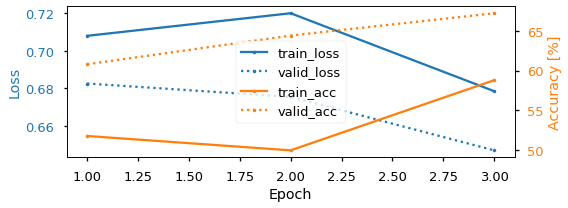

In [18]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

# Extract loss and balanced accuracy values for plotting from history object
df = pd.DataFrame(clf.history.to_list())

df['train_acc'] *= 100
df['valid_acc'] *= 100

ys1 = ['train_loss', 'valid_loss']
ys2 = ['train_acc', 'valid_acc']
styles = ['-', ':']
markers = ['.', '.']

plt.style.use('seaborn-talk')

fig, ax1 = plt.subplots(figsize=(8, 3))
ax2 = ax1.twinx()
for y1, y2, style, marker in zip(ys1, ys2, styles, markers):
    ax1.plot(df['epoch'], df[y1], ls=style, marker=marker, ms=7,
             c='tab:blue', label=y1)
    ax2.plot(df['epoch'], df[y2], ls=style, marker=marker, ms=7,
             c='tab:orange', label=y2)

ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylabel('Loss', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.set_ylabel('Accuracy [%]', color='tab:orange')
ax1.set_xlabel('Epoch')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2)

plt.tight_layout()

We also display the confusion matrix and classification report for the
pretext task:




In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Switch to the test sampler
clf.iterator_valid__sampler = test_sampler
y_pred = clf.forward(splitted['test'], training=False) > 0
y_true = [y for _, _, y in test_sampler]

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[ 66  55]
 [ 23 106]]
              precision    recall  f1-score   support

         0.0       0.74      0.55      0.63       121
         1.0       0.66      0.82      0.73       129

    accuracy                           0.69       250
   macro avg       0.70      0.68      0.68       250
weighted avg       0.70      0.69      0.68       250



In [20]:
# fitting raw EEG data to the modl

X = mne.io.read_raw_fif(path_to_sample+"0-raw.fif")


Opening raw data file /home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/braindecode_code/sleep_staging_dataset/0-raw.fif...
Isotrak not found
    Range : 2883000 ... 5391000 =  28830.000 ... 53910.000 secs
Ready.


In [21]:
X_df = X.to_data_frame()
# X_arr = np.array(X.to_data_frame())
X_list = list(zip(X_df['Fpz-Cz'], X_df['Pz-Oz']))
X_tensor = torch.Tensor(X_list)

In [22]:
emb = model.get_submodule("emb")
emb_fe = model.get_submodule("emb.feature_extractor")

In [23]:
# embedder submodule - we want to remove feature classification and just use the nodes witht he convolutions, batch normalization and max pooling
# scope is to see what the pre-trained model comes up with

print(type(model))
model

<class '__main__.ContrastiveNet'>


ContrastiveNet(
  (emb): SleepStagerChambon2018(
    (spatial_conv): Conv2d(1, 2, kernel_size=(2, 1), stride=(1, 1))
    (feature_extractor): Sequential(
      (0): Conv2d(1, 16, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(1, 13), stride=(1, 13), padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(16, 16, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool2d(kernel_size=(1, 13), stride=(1, 13), padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Sequential(
      (0): Dropout(p=0, inplace=False)
      (1): Linear(in_features=544, out_features=100, bias=True)
    )
  )
  (clf): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [24]:
# Does not work:
# Data is in wrong format OR it does not satisfy arguments of .forward() function
# still figuring this one out...
X[0]
x_1 = torch.from_numpy(X[0][0])
x_2 = torch.from_numpy(X[0][1])

In [25]:
# model([x_1, x_2])
# emb(torch.randn(2, 1000))

N, D_in, H, D_out = 64, 1000, 100, 10

x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

_model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

In [26]:
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = _model(x)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # Zero the gradients before running the backward pass.
    _model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the _model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the _model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in _model.parameters():
            param -= learning_rate * param.grad

99 2.4183855056762695
199 0.033818475902080536
299 0.0012862526345998049
399 6.936051067896187e-05
499 4.408575023262529e-06


In [27]:
# model.emb(torch.from_numpy(X[0][0]))

_data = mne.io.read_raw_edf("/home/maligan/mne_data/physionet-sleep-data/SC4001E0-PSG.edf")

Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [52]:
X = SleepPhysionet(
    subject_ids=[0],
    recording_ids=[1]
)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [59]:

X_windowed = create_windows_from_events(
    X, trial_start_offset_samples=0, trial_stop_offset_samples=0,
    window_size_samples=window_size_samples,
    window_stride_samples=window_size_samples)

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
837 matching events found
No baseline correction applied
0 projection items activated
Loading data for 837 events and 3000 original time points ...
0 bad epochs dropped


In [98]:
def print_dataset_stats(pre_train_data, input_data):
    print("- pre-training data -")
    print(type(pre_train_data))
    print("O:", len(pre_train_data))
    print("1:", len(pre_train_data[0]))
    print("2:", len(pre_train_data[0][0]))
    print("3:", len(pre_train_data[0][0][0]))

    print("------------------------------------------------------------------")

    print("- input data -")
    print(type(input_data))
    print("O:", len(input_data))
    print("1:", len(input_data[0]))
    print("2:", len(input_data[0][0]))
    print("3:", len(input_data[0][0][0]))

In [99]:
print_dataset_stats(dataset, _data)

- pre-training data -
<class 'braindecode.datasets.sleep_physionet.SleepPhysionet'>
O: 11679004
1: 2
2: 2
3: 1
------------------------------------------------------------------
- input data -
<class 'mne.io.edf.edf.RawEDF'>
O: 7950000
1: 2
2: 1
3: 7950000


In [95]:
torch.from_numpy(_data)

TypeError: expected np.ndarray (got RawEDF)

In [44]:
from braindecode.datautil.windowers import create_windows_from_events


_data_windows = create_windows_from_events(
    _data, trial_start_offset_samples=0, trial_stop_offset_samples=0,
    window_size_samples=window_size_samples,
    window_stride_samples=window_size_samples,
    preload=True
    )


AttributeError: 'RawEDF' object has no attribute 'datasets'

11679004

In [ ]:
################################################################################################################################################

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [2, 1, 2, 1], but got 2-dimensional input of size [2508001, 2] instead

In [167]:
X_arr.ndim

2

### Using the learned representation for sleep staging




We can now use the trained convolutional neural network as a feature
extractor. We perform sleep stage classification from the learned feature
representation using a linear logistic regression classifier.




In [ ]:
from torch.utils.data import DataLoader
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Extract features with the trained embedder
data = dict()
for name, split in splitted.items():
    split.return_pair = False  # Return single windows
    loader = DataLoader(split, batch_size=batch_size, num_workers=num_workers)
    with torch.no_grad():
        feats = [emb(batch_x.to(device)).cpu().numpy()
                 for batch_x, _, _ in loader]
    data[name] = (np.concatenate(feats), split.get_metadata()['target'].values)

# Initialize the logistic regression model
log_reg = LogisticRegression(
    penalty='l2', C=1.0, class_weight='balanced', solver='lbfgs',
    multi_class='multinomial', random_state=random_state)
clf_pipe = make_pipeline(StandardScaler(), log_reg)

# Fit and score the logistic regression
clf_pipe.fit(*data['train'])
train_y_pred = clf_pipe.predict(data['train'][0])
valid_y_pred = clf_pipe.predict(data['valid'][0])
test_y_pred = clf_pipe.predict(data['test'][0])

train_bal_acc = balanced_accuracy_score(data['train'][1], train_y_pred)
valid_bal_acc = balanced_accuracy_score(data['valid'][1], valid_y_pred)
test_bal_acc = balanced_accuracy_score(data['test'][1], test_y_pred)

print('Sleep staging performance with logistic regression:')
print(f'Train bal acc: {train_bal_acc:0.4f}')
print(f'Valid bal acc: {valid_bal_acc:0.4f}')
print(f'Test bal acc: {test_bal_acc:0.4f}')

print('Results on test set:')
print(confusion_matrix(data['test'][1], test_y_pred))
print(classification_report(data['test'][1], test_y_pred))

AttributeError: 'str' object has no attribute 'decode'

The balanced accuracy is much higher than chance-level (i.e., 20% for our
5-class classification problem). Finally, we perform a quick 2D visualization
of the feature space using a PCA:




In [ ]:
from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
from matplotlib import cm

X = np.concatenate([v[0] for k, v in data.items()])
y = np.concatenate([v[1] for k, v in data.items()])

pca = PCA(n_components=2)
# tsne = TSNE(n_components=2)
components = pca.fit_transform(X)

fig, ax = plt.subplots()
colors = cm.get_cmap('viridis', 5)(range(5))
for i, stage in enumerate(['W', 'N1', 'N2', 'N3', 'R']):
    mask = y == i
    ax.scatter(components[mask, 0], components[mask, 1], s=10, alpha=0.7,
               color=colors[i], label=stage)
ax.legend()

We see that there is sleep stage-related structure in the embedding. A
nonlinear projection method (e.g., tSNE, UMAP) might yield more insightful
visualizations. Using a similar approach, the embedding space could also be
explored with respect to subject-level features, e.g., age and sex.




## Conclusion




In this example, we used self-supervised learning (SSL) as a way to learn
representations from unlabelled raw EEG data. Specifically, we used the
relative positioning (RP) pretext task to train a feature extractor on a
subset of the Sleep Physionet dataset. We then reused these features in a
downstream sleep staging task. We achieved reasonable downstream performance
and further showed with a 2D projection that the learned embedding space
contained sleep-related structure.

Many avenues could be taken to improve on these results. For instance, using
the entire Sleep Physionet dataset or training on larger datasets should help
the feature extractor learn better representations during the pretext task.
Other SSL tasks such as those described in [1]_ could further help discover
more powerful features.


## References

.. [1] Banville, H., Chehab, O., Hyvärinen, A., Engemann, D. A., & Gramfort, A.
      (2020). Uncovering the structure of clinical EEG signals with
      self-supervised learning. arXiv preprint arXiv:2007.16104.

.. [2] Kemp, B., Zwinderman, A. H., Tuk, B., Kamphuisen, H. A., & Oberye, J. J.
       (2000). Analysis of a sleep-dependent neuronal feedback loop: the
       slow-wave microcontinuity of the EEG. IEEE Transactions on Biomedical
       Engineering, 47(9), 1185-1194.

.. [3] Goldberger, A. L., Amaral, L. A., Glass, L., Hausdorff, J. M., Ivanov,
       P. C., Mark, R. G., ... & Stanley, H. E. (2000). PhysioBank,
       PhysioToolkit, and PhysioNet: components of a new research resource for
       complex physiologic signals. circulation, 101(23), e215-e220.

.. [4] Chambon, S., Galtier, M., Arnal, P., Wainrib, G. and Gramfort, A.
      (2018)A Deep Learning Architecture for Temporal Sleep Stage
      Classification Using Multivariate and Multimodal Time Series.
      IEEE Trans. on Neural Systems and Rehabilitation Engineering 26:
      (758-769)


